In [ ]:
!pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
import numpy as np
import yfinance as yf

In [ ]:
# Let us  get historical stock prices for Amazon
# covering the past few years
stock_data = yf.Ticker("AMZN")
c_data = stock_data.history(start = '2020-04-01', end = '2023-10-01')

val_data = stock_data.history(start = '2023-10-01', end = '2023-11-27')

In [ ]:
#Preprocess data
df = c_data.copy()
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.set_index('Date', inplace=True)
df = df['Close'].to_frame()

In [ ]:
  #changing dataset to log(dataset) values
data = np.log(df)

  #splitting dataset for train and test
train_data, test_data = data[3:int(len(data)*0.9)], data[int(len(data)*0.9):]

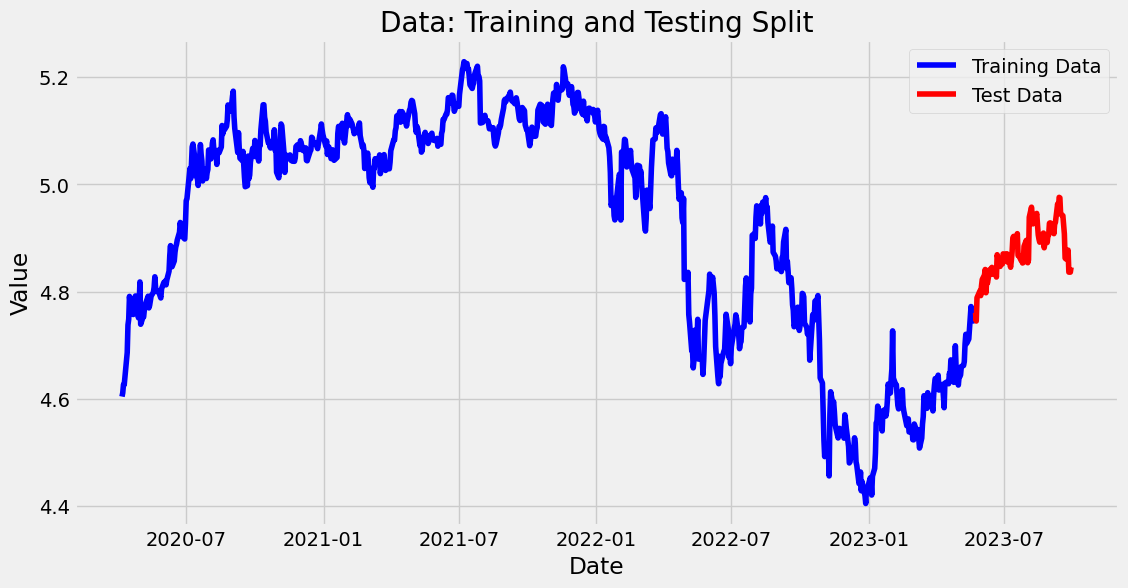

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data', color='blue')
plt.plot(test_data, label='Test Data', color='red')
plt.title('Data: Training and Testing Split')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

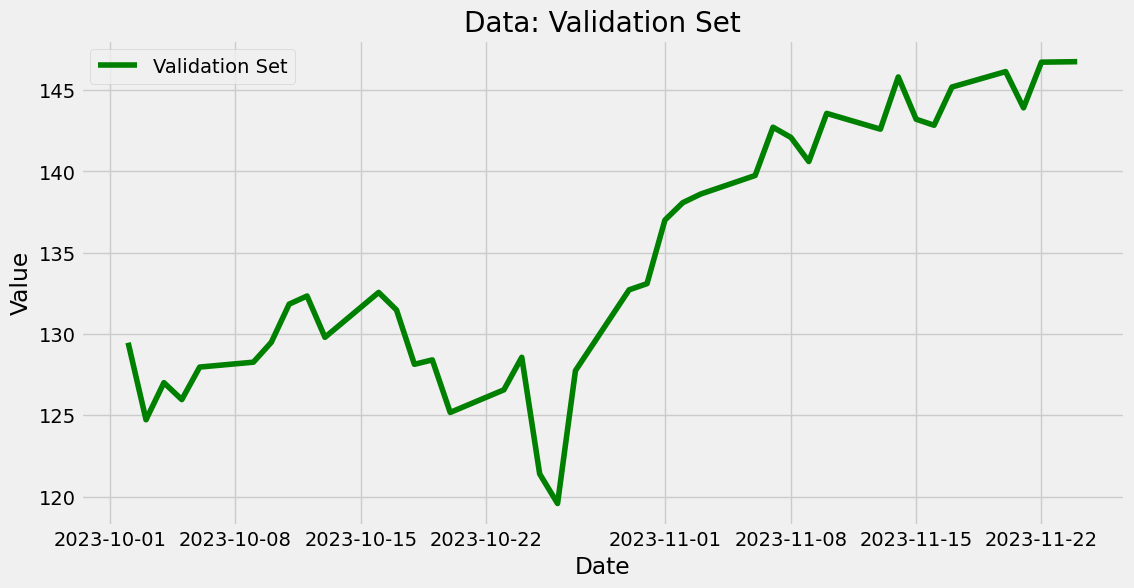

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(val_data['Close'], label = 'Validation Set', color='green')
plt.title('Data: Validation Set')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
  #calculating p,d,q values for ARIMA based on training data
  #auto_arima process identifies the most optimal parameters for an ARIMA model
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       #type of root test
                      max_p=4, max_q=4, #max_p is the max value of AR and max_q is the max value of MA
                      m=1,              #annual data
                      d=None,
                      seasonal=True,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
#summary to choose p,d,q value and update it accordingly in arima function
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3630.193, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3628.202, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3628.201, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3632.149, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3626.202, Time=0.40 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.122 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  789
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1817.075
Date:                Wed, 29 Nov 2023   AIC                          -3632.149
Time:                        04:08:51   BIC                          -3627.480
Sample:                             0   HQIC                         -3630.354
                                - 789                                  

In [ ]:
  #using the predicted p,d,q value from above result to train the arima model
model = ARIMA(train_data, order=(0, 1, 0))
  #fits model by exact maximum likelihood
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  789
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1817.075
Date:                Wed, 29 Nov 2023   AIC                          -3632.149
Time:                        04:08:51   BIC                          -3627.480
Sample:                             0   HQIC                         -3630.354
                                - 789                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0006   1.67e-05     34.761      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               563.83
Prob(Q):                              0.92   Pr

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
#forecast or predicting the stock prices and comparing it in the graph
forecast_result = fitted.forecast(len(test_data), alpha=0.05)

if len(forecast_result) == 3:
    fc = forecast_result
    se = forecast_result
    conf = forecast_result
    fc_series = pd.Series(fc, index=test_data.index)
    lower_series = pd.Series(conf[:, 0], index=test_data.index)
    upper_series = pd.Series(conf[:, 1], index=test_data.index)
else:
    # Handle the case where the method returns only two values
    # Modify this part based on what the method returns
    fc = forecast_result
    conf = forecast_result
    fc_series = pd.Series(fc, index=test_data.index)
    lower_series = pd.Series(conf, index=test_data.index)
    upper_series = pd.Series(conf, index=test_data.index)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
# Generate error data for test
  #mean squared error
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
  #mean absolute error
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
  #root mean squared error
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
  #mean absolute percentage error
mape = mean_absolute_percentage_error(test_data, fc)
print('MAPE: '+str(mape))

MSE: 0.01960330730961799
MAE: 0.131888894857187
RMSE: 0.1400118113218238
MAPE: 0.026953993956874
